# Chapter 4 Training Models

So far we have treated Machine Learning models and their training algorithms mostly like black boxes.If you went through some of the exercises in the previous chapters,you may have been surprised by how much you can get done without knowing anything about what's under the hood:you optimised a regression system,you improved a digit image classifer,and you even built a sapm classifer from scratch,all this without knowing how they actually work.Indeed, in many situations you do not really know the implementation details.

However,having a good understanding of how things work can help you quickly home in on the appropriate model,the right training algorithm to use,and a good set of hyperparameters for your task.Undersatanding what is under the hood will also help you debug issues and perform error analysis more efficiently.Lastly,most of the topics discussed in this chapter will be essential i understanding,building,and training neural networks(discussed in Part 2 of this book).

In this chapter we will start by looking at the Linear Regression model,one of the simplest models there is .We will discuss two very different ways to train it:

* Using a direct "closed-form" equation that directly computes the model parameters that best fit the model to the training set(i.e.,  the model parameters that minimize the cost function over the training set)

* Using an iterative optimization approach called Gradient(CD) that gradually tweaks the model parameters to minimize the cost function over the training set,eventually converging to the same set of paramaters as the first method.We will look at a few variants of Gradient Descent that we will use again and again when we study neural networks in PARAT 2.

Next we will look at Polynomial Regression,a more complex model that can fit non-linear datasets. Since this model has more parameters than Linear Regression,it is more prone to overfitting the training data,so we will look at how to detect whether or not this is the case using learning curves, and then we will look at several regularization techniques that can reduce the risk of overfitting the training set.

Finally,we will look at two more models that are commonly used for classification tasks: Logistic Regression and Softmax Regression.

There will be quite a few math equations in this chapter,using basic notions of linear algebra and calclus. To understand these equations,you will need to know what vectors and matrices are;how to transpose them ,multiply them,and inverse them;and what partial derivatives are.If you are unfamiliar with these concepts,please go through the linear algebra and calculus introductory tutorials available as Jupyter notebooks in the online supplemental material.For those who are truly allergic to mathematics, you should still go through this chapter and simply skip the equations;hopefully, the text will be sufficient to help you understand most of the concepts.

# Linear regression
More generally, a linear model makes a prediction by simply computing a weighted sum of the input features,plus a constant called the bias term(also called the intercept term),as shown in Equation 4-1.

Equation4-1 Linear Regression model prediction

# The Normal Equatin

Let us generate some linear-looking data to test this equation

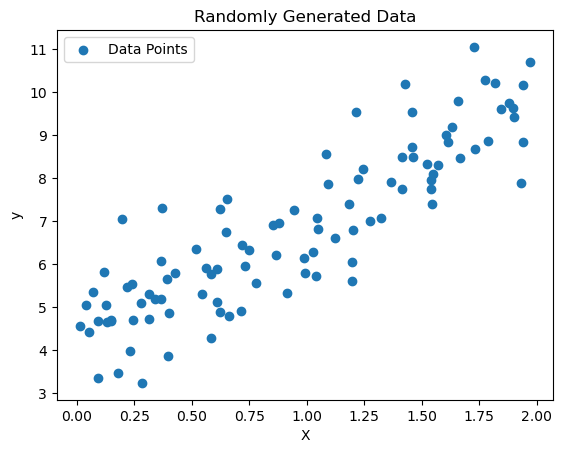

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random data
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Plot the generated data
plt.scatter(X, y, label='Data Points')
plt.title('Randomly Generated Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()



In [3]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)


The functionthat we used to generate the data is  y = 4 + 3x1 + Gaussian noise.Let us see what the equation found

In [4]:
theta_best

array([[4.21509616],
       [2.77011339]])

Close enough,but the noise made it impossible to recover the exact parameters of the original function.Now we can make predictions using 

In [9]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

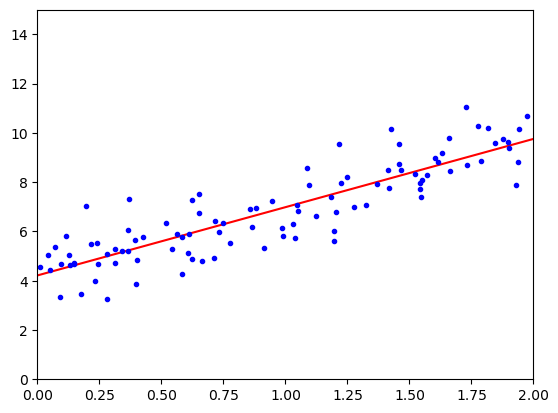

In [12]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

figure 4-2 Linear regression model predictions
Performing Linear Regression using Scikit-leaen is simple:

In [13]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_


(array([4.21509616]), array([[2.77011339]]))

The LinearRegression class is based on the scipy.linalg.lstsq() function(the name stands for "least squares"),which you could call directly:

In [14]:
>>> theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
>>> theta_best_svd

array([[4.21509616],
       [2.77011339]])

1.Normal Equation('theta_best')
2.Scikit-Learn's 'LinearRegssion'
3.Pseudoinverse with SVD('theta_best_svd'):

Three approaches aim to find the optimal parameters for a linear regression model.
The Normal Equation and the pseudoinverse methds are closely related,but the pseudinverse is more numerically stable.
Scikit-Learn's LinearRegression provides a convenient and efficient way to perform linear regression without explicitly dealing with matrix inversions or pseudoinverses.

# 4.1.2 Computational Complexity
The Normal Equation computes the inverse of XtX,which is an  (n+1)X(n+1) matrix(where n is the number of features). The computational complexity of inverting such a matrix is typically about ,depending on the implementation.

Now we will look at a very different way to train a Linear Regression model,which is better suited fro cases for cases where there are a large number of features or too many training instances to fit in memory.

# 4.2 Gradient Descent
Gradient Descent is a generic optimization algorsithm capable of finding optimal solutions  to a wide range of problems.The genreal idea of gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

Concretely,you start by filling @ with random values (this is called random initialization).Then you improve it gradually,taking one babby step at a time,each step attempting to decrease the cost function(e.g.,the MSE),until the algorithm converges to a minimum.

In this depiction of Gradient Descent, the model parameters are intialized randomly and get tweaked repeatedly to minimize the cost function;the learning step size is proportional to the slope of the cost fucnction ,so the steps gradually get smaller as the parameters approach the minimum.

An important parameter in Gradient Dwscent is the size of the steps,determined by the learning rate hyperparameter.If the learning rate is too small,then the algorithm will have to go through many iterations to converge,which will take a long time.

When using Gradient Descent,you should ensure that all features have a similar scale (e.g.,using Scikit-Learn's StandardScaler class), or else it will take much longer to converge.

Fortunately,since the cost function is convex in the case of Linear Regression,the needle is simply at the bottom of the bowl.

# 4.2.1 Batch gradient Descent
Equation  Partial derivatives of the cost function
Gradient vector of the cost function


In [32]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100
theta = np.random.randn(2, 1)  # random initialization
gradient_threshold = 1e-5  # set your desired threshold for convergence

print("Initial theta:")
print(theta)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
    # Calculate and print the magnitude of gradients
    gradient_magnitude = np.linalg.norm(gradients)
    print("Iteration {}: Gradient Magnitude: {:.6f}".format(iteration, gradient_magnitude))
    
    # Check for convergence
    if gradient_magnitude < gradient_threshold:
        print("\nConverged after {} iterations.".format(iteration + 1))
        break

print("\nFinal theta after {} iterations:".format(iteration + 1))
print(theta)



Initial theta:
[[1.08305124]
 [1.05380205]]
Iteration 0: Gradient Magnitude: 13.881379
Iteration 1: Gradient Magnitude: 8.154403
Iteration 2: Gradient Magnitude: 4.796290
Iteration 3: Gradient Magnitude: 2.830761
Iteration 4: Gradient Magnitude: 1.685828
Iteration 5: Gradient Magnitude: 1.027042
Iteration 6: Gradient Magnitude: 0.658764
Iteration 7: Gradient Magnitude: 0.464052
Iteration 8: Gradient Magnitude: 0.368269
Iteration 9: Gradient Magnitude: 0.322574
Iteration 10: Gradient Magnitude: 0.298917
Iteration 11: Gradient Magnitude: 0.284105
Iteration 12: Gradient Magnitude: 0.272778
Iteration 13: Gradient Magnitude: 0.262916
Iteration 14: Gradient Magnitude: 0.253777
Iteration 15: Gradient Magnitude: 0.245086
Iteration 16: Gradient Magnitude: 0.236740
Iteration 17: Gradient Magnitude: 0.228695
Iteration 18: Gradient Magnitude: 0.220929
Iteration 19: Gradient Magnitude: 0.213429
Iteration 20: Gradient Magnitude: 0.206184
Iteration 21: Gradient Magnitude: 0.199186
Iteration 22: Gradi

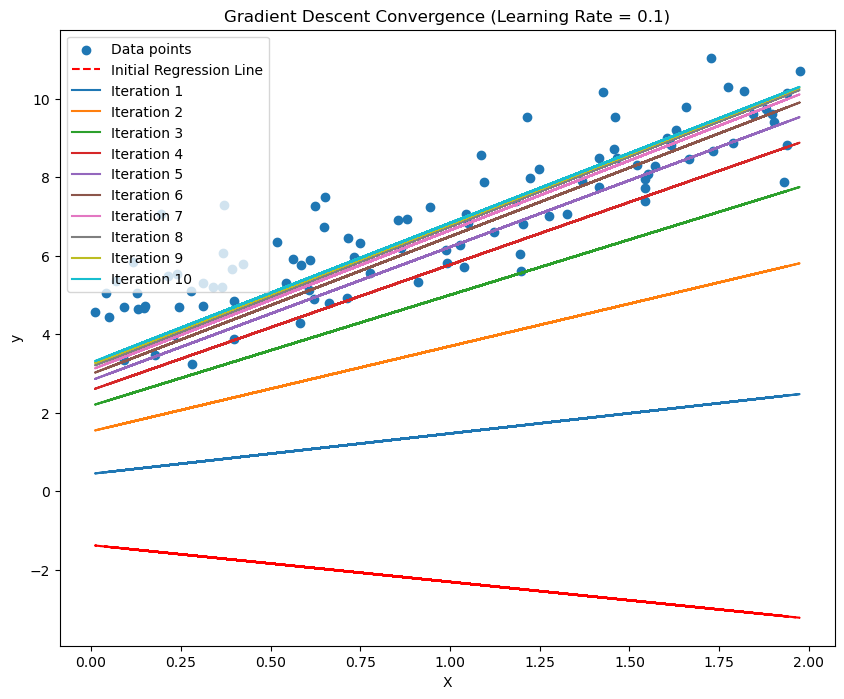

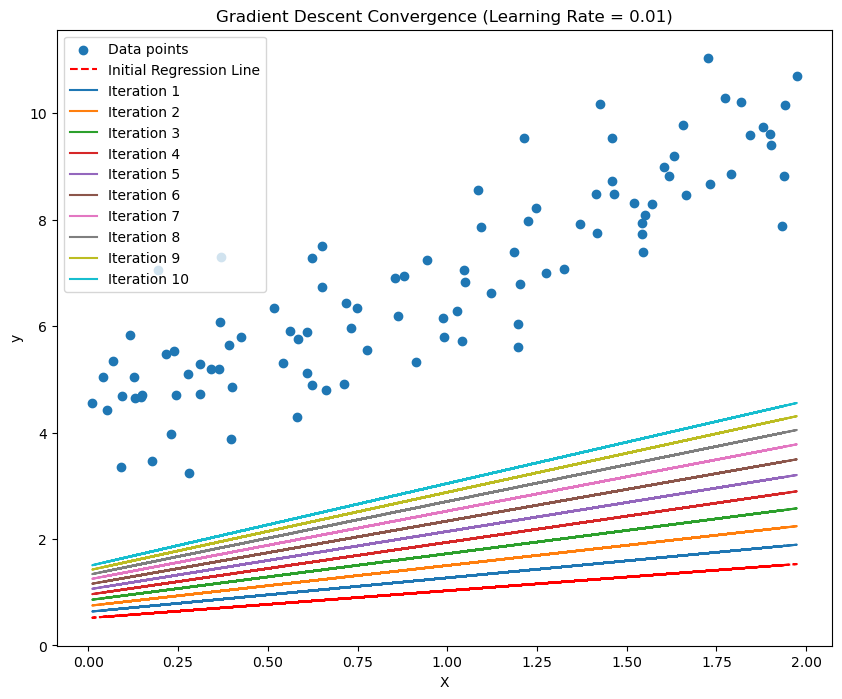

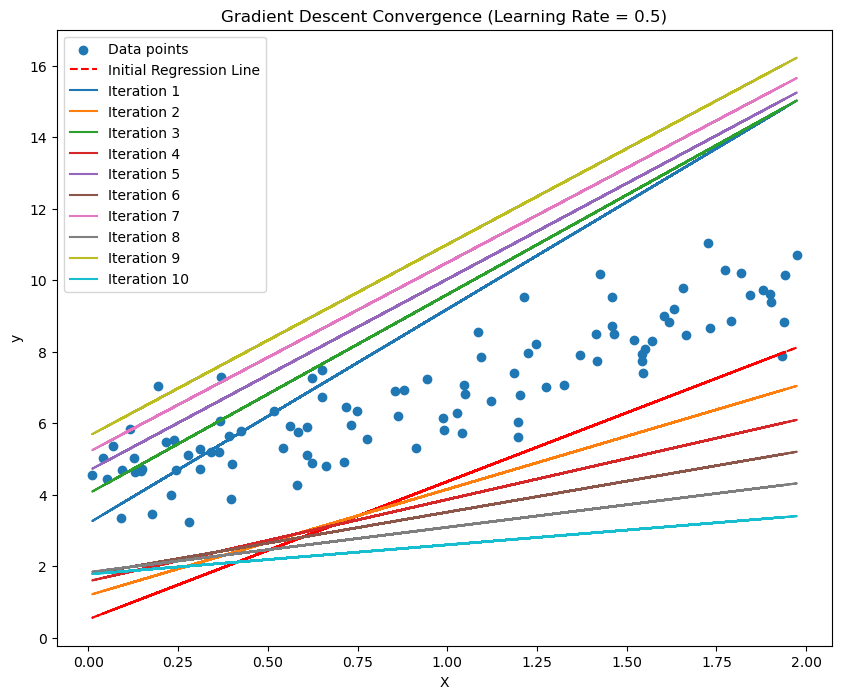

In [35]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Function to plot the data and regression line for the first 10 steps
def plot_first_10_steps(X, y, theta, learning_rate, n_iterations):
    x_values = X[:, 1]
    y_values = y.reshape(-1)
    initial_regression_line = X.dot(theta).reshape(-1)

    plt.figure(figsize=(10, 8))
    plt.scatter(x_values, y_values, label='Data points')
    plt.plot(x_values, initial_regression_line, 'r--', label='Initial Regression Line')

    for iteration in range(min(n_iterations, 10)):
        gradients = 2/m * X.T.dot(X.dot(theta) - y)
        theta = theta - learning_rate * gradients
        regression_line = X.dot(theta).reshape(-1)
        plt.plot(x_values, regression_line, label=f'Iteration {iteration + 1}')

    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'Gradient Descent Convergence (Learning Rate = {learning_rate})')
    plt.show()

# Plot the first 10 steps with different learning rates
learning_rate_1 = 0.1
learning_rate_2 = 0.01
learning_rate_3 = 0.5

# Plot for learning rate = 0.1
theta = np.random.randn(2, 1)  # random initialization
plot_first_10_steps(X_b, y, theta, learning_rate_1, n_iterations)

# Plot for learning rate = 0.01
theta = np.random.randn(2, 1)  # random initialization
plot_first_10_steps(X_b, y, theta, learning_rate_2, n_iterations)

# Plot for learning rate = 0.5
theta = np.random.randn(2, 1)  # random initialization
plot_first_10_steps(X_b, y, theta, learning_rate_3, n_iterations)


# Stochastic Gradient descent

# Mini-batch Gradiet Descent

The last Gradiet Descent algorithm we will look at is called Mini-batch Gradient Descent.It is simple to undertsand once you know Batch and Stochastic Gradient Descent:at each step,instead of computing the gradients based on the full training set(as in Batch GD) or based on just one instance (as in Stochastic GD),Mini-batch GD computes the gradients on small random sets of instances called mini-batches.The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations,especially when using GPUs.

The algorithm's progress in parameter space is less erratic than with Stochastic GD, especially with fairly large mini-batches.As a result,Mini-batch GD will end up walking around a bit closer to the minimum than Stochastic GD-but it may be harder for it to escape from local minima(in the case of problems that suffer from local minima,unlike Linear Regression).Figure shows the paths taken by the three Gradient Descent algorithms in parameter space during training.They all end up near the minimum,but Batch GD's path actually stops at the minimum,while both Stochastic GD and Mini-batch continue to walk around.However, don't forget that Batch Gd takes a lot of time to take each step,and Stochastic GD and Mini-batch GD would also reach the minimum if you used a good learning schedule.

Let us compare the algorithms we have discussed so far for Linear Regression(recall that m is the number of training instances and n is the numeber of features)

Comparison of algorithms for Linear Regression:
Algorithms          Large m   Out-of-Core support Large n Hyperparms Scaling requrired Scikit-Learn
Normal Equation
SVD
Batch GD
Stochastic GD
Mini-batch GD

There is almost no difference after training: all these algorithms end up with very similar models and make predictions in exactly the same way.

# Polynomial Regression


What if your data is more complex than a straight line?Surprisingly,you can use a linear model to fit nonlinear data.A simple way to do this is to add powers of each feature as new features,then train a linear model on this extended set of features.This  technique is called polynomial Regresion.

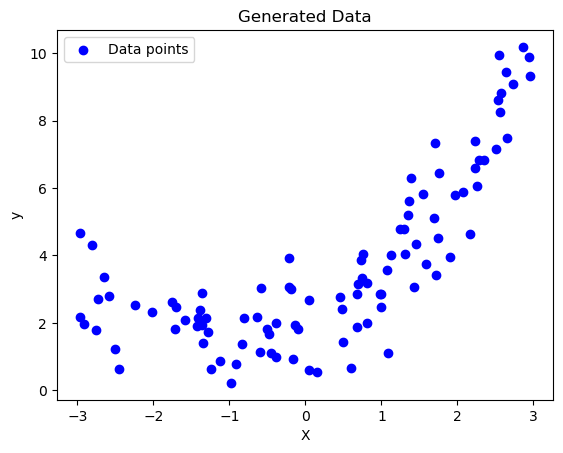

In [1]:
import numpy as np
import matplotlib.pyplot as plt
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

# Plotting the data
plt.scatter(X, y, color='blue', label='Data points')
plt.title('Generated Data')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Clearly, a straight line will never fit this data properly.So let's use Scikit-Learn's PolynomialFeatures class to transform our training data,adding the square(second degree polynomial) of each feature in the training set as  a new feature(in this case there is just one feature):


In [2]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]


array([0.45955516])

In [3]:
X_poly[0]

array([0.45955516, 0.21119095])

In [4]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_


(array([1.94287889]), array([[1.04119616, 0.51704453]]))

Not bad: the model  estimates when in fact the origial function was y = 0.5 *x1*x1 + 1.0*x1 +2.0 + Gaussian noise.

# Learning Curves
If you perform high-degree Polynomial Regression,you will likely fit the training data much better than with plain Linear Regrssion.

This high-degree Polynomial REgression model is severaly overfitting the training data,while the linear model is underfitting it.The mdeol that will generalize best in thsi case is the quadratic model,which make sense because the data was generated using a quadratic model.But in gereral you won't know waht function generated the data,so how can you decide how complex youe model should be?How can you tell that your model is overfitting or underfitting the data?

In Chapter 2 you used cross-validation to get an estimate of a mdoel's generalization performance.If a mdoel performs well on the training data but generalizes poorly according to the cross-validation metrics,then your model is overfitting.If it performs poorly on both,then it is underfitting.This is one way to tell when a model is too simple or too complex.

Another way to tell is to look at the learning curves:these are plots of the model's performance on the training set and the validation set as a function of the training setsize(or the training iteration).To generate the plots,train the model several times on different sized sunsets of the training set.The follwing code defines a function that,given some trainging data,plots the learning curves of a model:

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")


Let us look at the  learning curves of the plain Linear Regression model(a straight line):

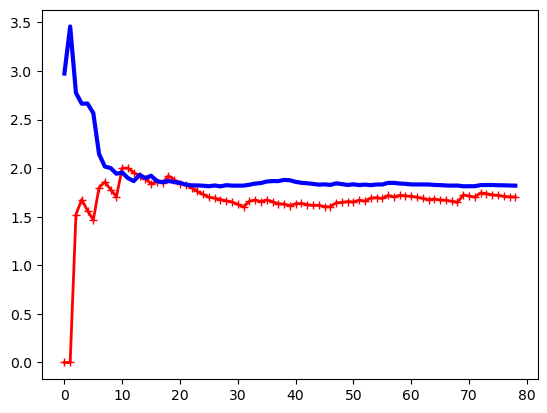

In [7]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X,y)

This model that is underfitting deserves a bit of  explaination.First,let us look at the performance on the training data:when there are just one or two instances in the training set,the model can fit them perfectly,which is why the curve starts at zero.But as new instances are added to the training set,it becomes impossible for the model to fit the training data perfectly,both because the data is noisy and because it is not linear at all.So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set does not make the average error much better or worse.Now let us look at the performance of the model on the validation data.When the model is trained on very few training instances,it is incapable of generaizing properly,which is why the validation errors is initially quite big.Then, as the model is shown more training examples,it learns ,and thus the validation error slowly goes down.However,once again a straight line cannot do a good job modeling the data,so the error ends up at a plateau,very clsoe to the other curve.

These learning curves are typical of a mdoel that is underfitting.Both curves have reached a plateau;they are close and fairly high.

If your model is underfitting the training data,adding more training examples will not help.You need to use a more complex model or come up with better features.

Now let us look at the learning curves of a 10th-degree polynomial model on the same data:

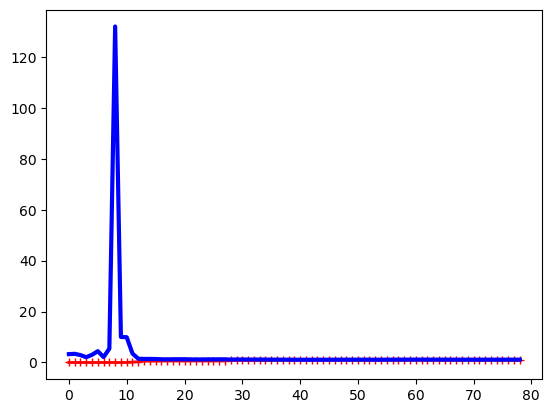

In [9]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
 ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
 ("lin_reg", LinearRegression()),
 ])
plot_learning_curves(polynomial_regression, X, y)

Overfitting occurs when a model learns not only the underlying patterns in the training data but also captures the noise or random fluctuations in that specific dataset.

Increaing the amount of training data is mentioned as a potential solution to overfitting.This is because providing more diverse examples to the model can help it generalize better.When a model is expected to a larger and more varied set of instances,it becomes less likel to memorize specific data points and is more likely to learning  the underlying patterns that are consistent across different instances.

In simpler terms,overfitting often happens when a model becomes too complex and starts memorizing the training data instead of learning the general patterns.By giving the model more examples to learn from, it has a better chance of understanding the true underlying patterns and avoiding the temptation to fit the nosie present in a smaller dataset.

However，it is important to note that just blindly increasing the amount of trainging data might not always be sufficient.Other regularization techniques or model simplification methods might also be needed to address overfitting.


The Bias/Variance Trade-off
Bias  /  Variance / Irreducible error

Increasing a model's complexity will typically increase its variance and reduce its bias.Convversely,reducing a model's compllexity increases its bias ad reduces its variance.This is why it is called a trade-off.

# Regularized Linear Models
As we saw previously,a good way to reduce overfitting is to regularize the model(to consttrain it): the fewer degrees of the freedom it has,the harder it will be for it yo overfit  the data.A simple way to regularize a polynomial model is to reduce the numebr of polynomial degrees.

For a linear model,regularization is tyically achieved by constraining the weights of the model.We will now look at Ridge Regrssion,Lasso Regression,and Elastic Net,which implement three different ways to contrain the weights

Ridge Regression
Ridge Regression(also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to   α∑i = 1
n
θi
2  is added to the cost  funciton.This forces the learning algorithm to not only fit the data but also keep the model weights as samll as possible.Note that the regularization term should only be added to the cost function  during training.Once the model is trained, you want yo use the unregularized performance measure to evaluate the model's performance.

The hyperparameter a controls how much you want  to regularize the model.If a = 0,then Ridge Regression is just Linear Regression.If a is very large ,then all weights end up very close to  zero and the result is a flat line going through the data's mean.

# Lasso Regression
Least Absolute Shrinkage and Selection Operator Regression(usually simply called Lasso regression) is another regularized version of Linear Regression:just like Ridge Regression,it adds a regularization term to the cost function, but it uses the l1 norm of the weight vector instaead of half the square of the l2 norm.

# Elastic Net
Elastic Net is a middle ground between Ridge Regression and Lasso Regression.The regularization term is a simple mix of both Ridge and Lasso's regularization terms,and you can control the mix ratio r.When r=0,Elastic Net is equivalent to Ridge REgression,and whe r =1, it is equivalent to Lasso Regression.

# Early Stopping
A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum.This is called early stopping.